# Effect of straylight correction on MRS RSRF

In [7]:
import funcs
import mrsobs

import numpy as np
from astropy.io import fits
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
bands = ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C", 
         "2AxB","2AxC","2BxA","2BxC","2CxA","2CxB",
         "3AxB","3AxC","3BxA","3BxC","3CxA","3CxB",
         "4AxB","4AxC","4BxA","4BxC","4CxA","4CxB"]

In [3]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'distortionMaps/'
dichroicDir   = workDir+'MRSWaveCal/MrsFilterTransmissions/'
lvl2path  = workDir+'FM_data/LVL2/'

# Populate dictionaries with the wavelength, pixel size and validity maps 
# (corresponding to the detector plane)

sliceMap  = {}
sizeMap   = {}
validMap  = {}
lambdaMap = {}

for band in bands:
    if len(band) == 4:
        # cross-dichroic configuration
        continue
    print "Band {}".format(band)
    d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
    sliceMap[band]  = d2cMaps['sliceMap']
    lambdaMap[band] = d2cMaps['lambdaMap']
    sizeMap[band]   = funcs.get_pixel_spatial_area(band=band,d2cMaps=d2cMaps)
    
    # create a "valid" map with all the pixels inside the slices of a particular band
    channel = int(band[0])
    # slice numbers in the slice map of the distortion CDP for this band
    sliceInventory = np.unique(sliceMap[band])
    slicesInBand = sliceInventory[np.where( (sliceInventory >= 100*channel ) & (sliceInventory <100*(channel+1)))]
    
    validMap[band] = np.zeros(sliceMap[band].shape)
    for ss in slicesInBand:
        s = int(ss - 100*channel)
        # construct a list of y,x coordinates of detector pixels belonging to slices of this band
        pixels = np.where(sliceMap[band] == ss)
        validMap[band][pixels] = 1

Band 1A
Band 1B
Band 1C
Band 2A
Band 2B
Band 2C
Band 3A
Band 3B
Band 3C
Band 4A
Band 4B
Band 4C


In [4]:
# Populate dictionaries with maps of L_sky

# Location where we have the L_sky files for different BB temperatures
MTSDir = workDir+"MRSFluxCal/MIRI_CDP6MRSFluxCal/MtsIrradiance/"
BBTemp = "800K"
L_skyMap = {}
tabLSky = fits.open(MTSDir+ "MTSEquivalentLsky" + BBTemp + ".fits" )[1]
ip_Lsky = interp1d(tabLSky.data["wave"], tabLSky.data["L_sky"], kind='cubic')
for band in bands:
    if len(band) == 4:
        # cross-dichroic configuration
        continue
    L_skyMap[band] = np.full( validMap[band].shape, np.nan )
    sel = (validMap[band]==1)
    waves = np.reshape(lambdaMap[band][sel], -1)
    L_skyMap[band][sel] = ip_Lsky(waves)*1000. #mJy/arcsec^2

In [5]:
# Populate dictionaries with maps of E_pix
# Calculate the spectral irradiance E_pix : [mJy/pixel]
# E_pix = omega_pix * L_pix
BBTemp = "800K"
E_pixMap = {}   
for band in bands:
    if len(band) == 4:
        # cross-dichroic configuration
        continue
    E_pixMap[band] = np.full( validMap[band].shape, np.nan )
    sel = (validMap[band]==1)
    E_pixMap[band][sel] = sizeMap[band][sel] * L_skyMap[band][sel]

In [8]:
# Populate dictionaries with maps of S_pix [DN/sec] and dS_pix (the error)
# S_pix is the average slope of the BB measurement with the average slope of the
# background measurement subtracted.
# We also populate the Bad pixel map (0 = ok, 1 = do not use)

BBTemp = "800K"
S_pixMap,S_pixMap_STRCORR = {},{}
dS_pixMap = {}
BadPixelMap = {}
for band in bands:
    print "Band {}".format(band)
    if len(band) == 4:
        # cross-dichroic configuration
        validMap[band] = validMap[band[:2]]
    S_pixMap[band] = np.full( validMap[band].shape, np.nan )
    S_pixMap_STRCORR[band] = np.full( validMap[band].shape, np.nan )
    dS_pixMap[band] = np.full( validMap[band].shape, np.nan )
    BadPixelMap[band] = np.full( validMap[band].shape, 0 )
    if len(band) == 4:
        # cross-dichroic configuration
        continue
    hdulist = fits.open(mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='800K',output='filename')[0])
    slopeHOLE = hdulist[0].data[0,:,:]
    slopeHOLE_STRCORR = funcs.straylightCorrection(slopeHOLE,sliceMap=sliceMap[band])
    dslopeHOLE = hdulist[0].data[1,:,:]
    maskHOLE = hdulist[0].data[2,:,:]
    hdulist = fits.open(mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='800K',output='filename')[1])
    slopeBLANK = hdulist[0].data[0,:,:]
    slopeBLANK_STRCORR = funcs.straylightCorrection(slopeBLANK,sliceMap=sliceMap[band])
    dslopeBLANK = hdulist[0].data[1,:,:]
    maskBLANK = hdulist[0].data[2,:,:]
    sel = (validMap[band]==1) & (maskHOLE==0) & (maskBLANK==0)
    S_pixMap[band][sel] = slopeHOLE[sel] - slopeBLANK[sel]
    S_pixMap_STRCORR[band][sel] = slopeHOLE_STRCORR[sel] - slopeBLANK_STRCORR[sel]
    dS_pixMap[band][sel] = np.sqrt(dslopeHOLE[sel]**2 + dslopeBLANK[sel]**2)
    BadPixelMap[band][(validMap[band]==1)& (maskHOLE>0) & (maskBLANK>0)] = 1

Band 1A
Band 1B
Band 1C
Band 2A
Band 2B
Band 2C
Band 3A
Band 3B
Band 3C
Band 4A
Band 4B
Band 4C
Band 2AxB
Band 2AxC
Band 2BxA
Band 2BxC
Band 2CxA
Band 2CxB
Band 3AxB
Band 3AxC
Band 3BxA
Band 3BxC
Band 3CxA
Band 3CxB
Band 4AxB
Band 4AxC
Band 4BxA
Band 4BxC
Band 4CxA
Band 4CxB


In [10]:
# Populate dictionaries with maps of R_pix [DN/sec/mJy/pixel] and dR_pix 
# 

R_pixMap = {}
dR_pixMap = {}

BBTemp = "800K"
R_pixMap,R_pixMap_STRCORR = {},{}
dR_pixMap = {}
for band in bands:
    if len(band) == 4:
        # cross-dichroic configuration
#         validMap[band] = validMap[band[:2]]
#         E_pixMap[band] = E_pixMap[band[:2]]
        continue
    R_pixMap[band] = np.full( validMap[band].shape, np.nan )
    R_pixMap_STRCORR[band] = np.full( validMap[band].shape, np.nan )
    dR_pixMap[band] = np.full( validMap[band].shape, np.nan )
    sel = (validMap[band]==1)& (BadPixelMap[band]==0)
    R_pixMap[band][sel] = S_pixMap[band][sel] / E_pixMap[band][sel]
    R_pixMap_STRCORR[band][sel] = S_pixMap_STRCORR[band][sel] / E_pixMap[band][sel]
    dR_pixMap[band][sel] = R_pixMap[band][sel] * dS_pixMap[band][sel]/S_pixMap[band][sel]

<IPython.core.display.Javascript object>


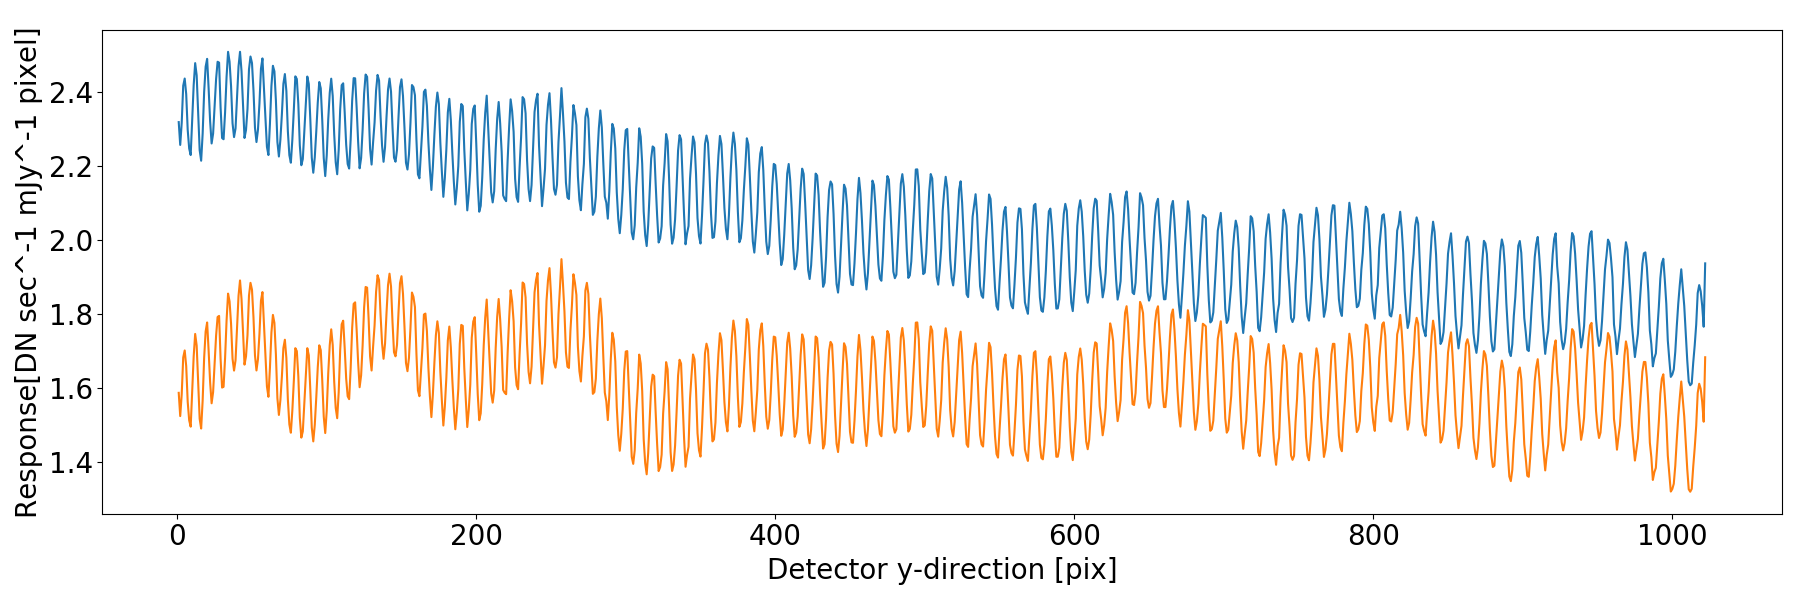

<IPython.core.display.Javascript object>


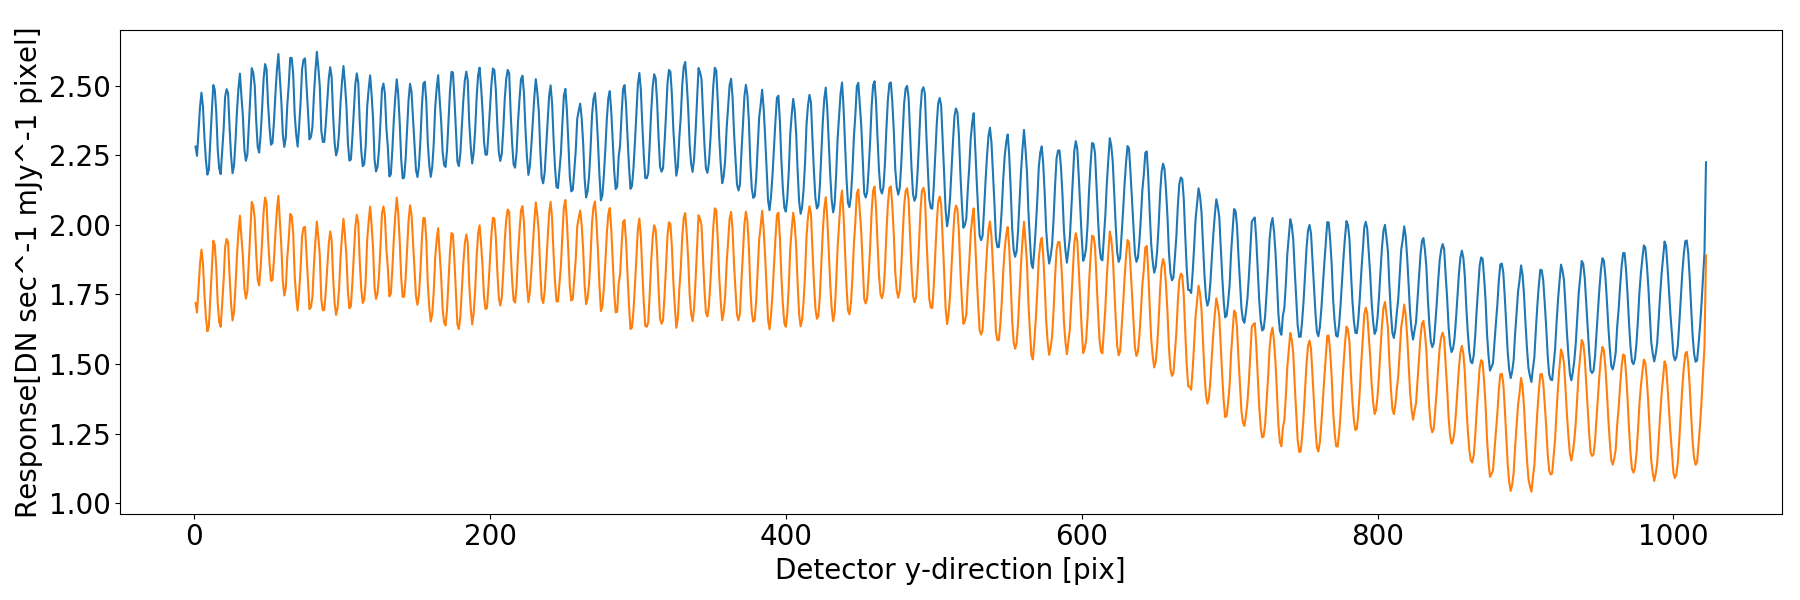

<IPython.core.display.Javascript object>


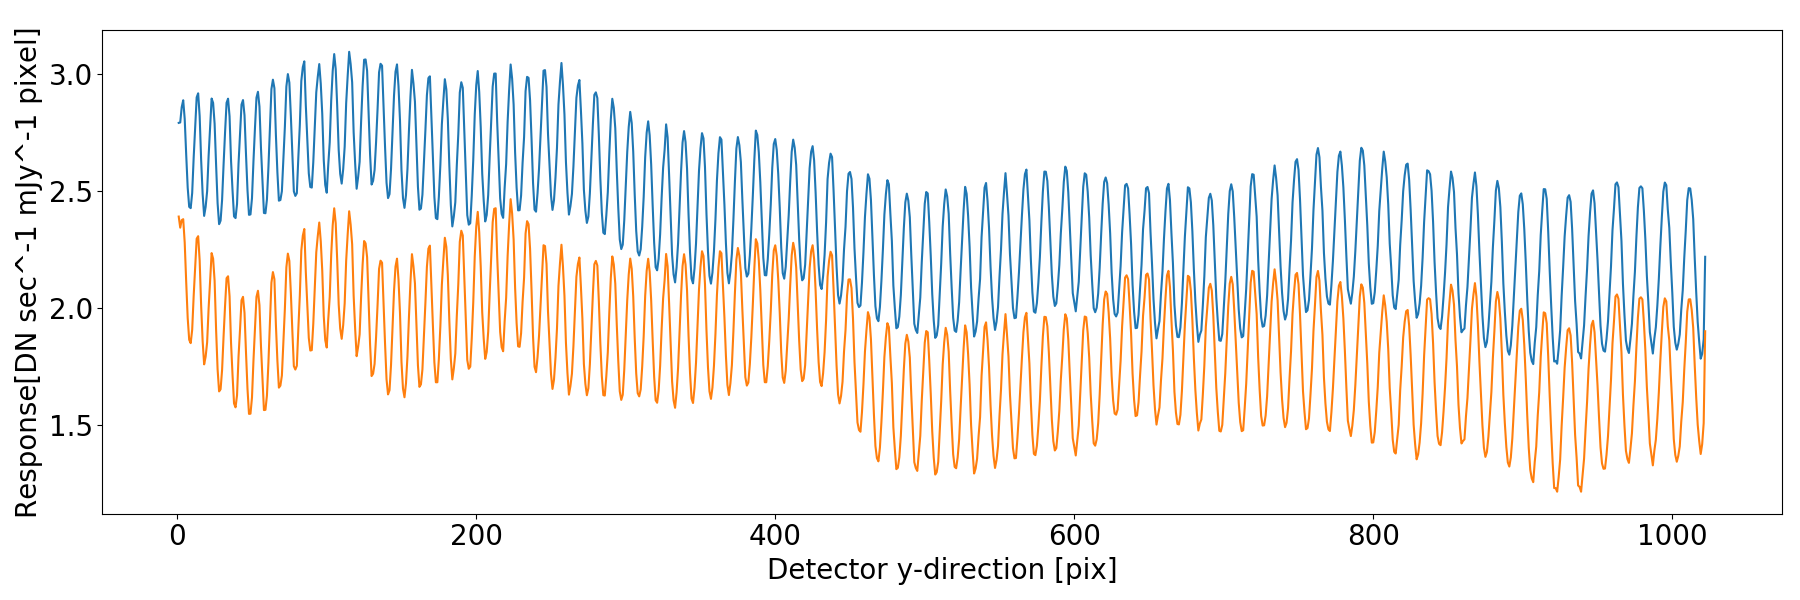

In [11]:
# band = '1A'
# plt.figure(figsize=(18,6))
# plt.plot(S_pixMap[band][512,:])
# plt.plot(S_pixMap_STRCORR[band][512,:])
# plt.xlabel('Detector y-direction [pix]')
# plt.ylabel('Signal [DN sec^-1]')
# plt.tight_layout()

for band in ["1A", "1B", "1C"]:
    plt.figure(figsize=(18,6))
    plt.plot(R_pixMap[band][:,47])
    plt.plot(R_pixMap_STRCORR[band][:,47])
    plt.xlabel('Detector y-direction [pix]')
    plt.ylabel('Response[DN sec^-1 mJy^-1 pixel]')
    plt.tight_layout()

# plt.figure(figsize=(18,6))
# plt.plot(((R_pixMap_STRCORR[band][:,48]/R_pixMap[band][:,48])-1)*100. )
# plt.xlabel('Detector y-direction [pix]')
# plt.ylabel('Response difference [%]')
# plt.tight_layout()

# plt.figure()
# plt.imshow(np.abs(((R_pixMap_STRCORR[band]/R_pixMap[band])-1)*100.),vmin=0,vmax=30)
# plt.tight_layout()

In [27]:
oldCdp = fits.open(cdpDir+"MIRI_FM_MIRIFUSHORT_SHORT_PHOTOM_06.03.02.fits")
dq_def = oldCdp[4]

In [28]:
outDir = cdpDir+"CDP7/"

In [29]:
def makeHeader(detector="MIRIFUSHORT", channel="12", band="SHORT"):
    hdu0 = fits.PrimaryHDU()
    hdu0.header["TELESCOP"]="JWST"
    hdu0.header["INSTRUME"]="MIRI"
    hdu0.header["MODELNAM"]=("FM", "Instrument model name")
    hdu0.header["DETECTOR"]=detector
    hdu0.header["DETSETNG"]="ANY"
    hdu0.header["READPATT"]="ANY"
    hdu0.header["SUBARRAY"]="GENERIC"
    hdu0.header["SUBSTRT1"]= 1                                            
    hdu0.header["SUBSIZE1"]= 1032                                              
    hdu0.header["SUBSTRT2"]= 1                                                
    hdu0.header["SUBSIZE2"]= 1024                                           
    hdu0.header["FASTAXIS"]= 1                                               
    hdu0.header["SLOWAXIS"]= 2
    hdu0.header["CHANNEL"] = channel
    hdu0.header["BAND"]    = band
    hdu0.header["FILENAME"]= "MIRI_FM_"+detector+"_"+channel+band+"_PHOTOM_7B.03.00.fits"
    hdu0.header["DATE"]="2017-01-24"
    hdu0.header["VERSION"] ="7B.03.00"
    hdu0.header["USEAFTER"] ="2000-01-01T00:00:00"
    hdu0.header["AUTHOR"]  ="Bart Vandenbussche"
    hdu0.header["ORIGIN"]  = "MIRI European Consortium"
    hdu0.header["EXP_TYPE"]= "MIR_MRS"
    hdu0.header["REFTYPE"] ="PHOTOM"
    hdu0.header["DESCRIP"] = 'CDP-7 MIRI MRS response'
    hdu0.header["PEDIGREE"] = 'GROUND'
    hdu0.header.add_history("DOCUMENT: MIRI-TN-00003-KUL issue 1.2")
    hdu0.header.add_history("SOFTWARE: MIRICLE ")
    hdu0.header.add_history("DATA USED: RAL FM data obsId 11282 .. 11287")
    hdu0.header.add_history("DIFFERENCES: 06.03.00 Detector plane calibration (new format)")
    hdu0.header.add_history("DIFFERENCES: 06.03.01 Corrected error in PIXSIZ extension")
    hdu0.header.add_history("DIFFERENCES: 06.03.02 Fringe flat 06.02.00 applied")
    hdu0.header.add_history("DIFFERENCES: 7B.03.00 Renumbered to CDP7 Beta / fixed USEAFTER")
    hdu0.header.add_history("DIFFERENCES: 7B.04.00 Used DHAS 9.2.4 to re-reduce the data")
    hdu0.header.add_history("DIFFERENCES: 7B.05.00 Straylight Correction v2 applied")
    return hdu0


In [30]:
from miri.datamodels.cdp import MiriFlatfieldModel
ff= {}
ff["LONGLONG"]=MiriFlatfieldModel(cdpDir+"MIRI_FM_MIRIFULONG_34LONG_FRINGE_06.02.00.fits").data
ff["LONGMEDIUM"]=MiriFlatfieldModel(cdpDir+"MIRI_FM_MIRIFULONG_34MEDIUM_FRINGE_06.02.00.fits").data
ff["LONGSHORT"]=MiriFlatfieldModel(cdpDir+"MIRI_FM_MIRIFULONG_34SHORT_FRINGE_06.02.00.fits").data
ff["SHORTLONG"]=MiriFlatfieldModel(cdpDir+"MIRI_FM_MIRIFUSHORT_12LONG_FRINGE_06.02.00.fits").data
ff["SHORTMEDIUM"]=MiriFlatfieldModel(cdpDir+"MIRI_FM_MIRIFUSHORT_12MEDIUM_FRINGE_06.02.00.fits").data
ff["SHORTSHORT"]=MiriFlatfieldModel(cdpDir+"MIRI_FM_MIRIFUSHORT_12SHORT_FRINGE_06.02.00.fits").data

# SHORT SHORT = 1A / 2A

In [31]:
hdu0 = makeHeader(detector="MIRIFUSHORT", channel="12", band="SHORT")

resp = R_pixMap["2A"].copy()
err = dR_pixMap["2A"].copy()
size = sizeMap["2A"].copy()

sel = (validMap["1A"]==1)
resp[sel] = R_pixMap["1A"][sel]
err[sel] = dR_pixMap["1A"][sel]
size[sel] = sizeMap["1A"][sel]

sel = (( validMap["1A"] + validMap["2A"] )==1)
resp[sel] = resp[sel]/ff["SHORTSHORT"][sel]

dq = np.full( validMap["1A"].shape, 2 ,dtype=float)
sel = (validMap["1A"]==1)
dq[sel] = 0
sel = (validMap["2A"]==1)
dq[sel] = 0
dq = dq + BadPixelMap["1A"]
dq = dq + BadPixelMap["2A"]

hdu1 = fits.ImageHDU(data=resp, header=None, name="SCI")
hdu1.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu2 = fits.ImageHDU(data=err, header=None, name="ERR")
hdu2.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu3 = fits.ImageHDU(data=dq, header=None, name="DQ")
hdu4 = fits.ImageHDU(data=size, header=None, name="PIXSIZ")
hdu4.header["BUNIT"]= "arcsec^2"
hdulist = fits.HDUList([hdu0,hdu1, hdu2, hdu3, dq_def, hdu4])
hdulist.writeto(outDir + "MIRI_FM_MIRIFUSHORT_12SHORT_PHOTOM_7B.04.00.fits",overwrite=True)

In [39]:
hdu0 = makeHeader(detector="MIRIFUSHORT", channel="12", band="SHORT")

resp = R_pixMap_STRCORR["2A"].copy()
err = dR_pixMap["2A"].copy()
size = sizeMap["2A"].copy()

sel = (validMap["1A"]==1)
resp[sel] = R_pixMap_STRCORR["1A"][sel]
err[sel] = dR_pixMap["1A"][sel]
size[sel] = sizeMap["1A"][sel]

sel = (( validMap["1A"] + validMap["2A"] )==1)
resp[sel] = resp[sel]/ff["SHORTSHORT"][sel]

dq = np.full( validMap["1A"].shape, 2 ,dtype=float)
sel = (validMap["1A"]==1)
dq[sel] = 0
sel = (validMap["2A"]==1)
dq[sel] = 0
dq = dq + BadPixelMap["1A"]
dq = dq + BadPixelMap["2A"]

hdu1 = fits.ImageHDU(data=resp, header=None, name="SCI")
hdu1.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu2 = fits.ImageHDU(data=err, header=None, name="ERR")
hdu2.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu3 = fits.ImageHDU(data=dq, header=None, name="DQ")
hdu4 = fits.ImageHDU(data=size, header=None, name="PIXSIZ")
hdu4.header["BUNIT"]= "arcsec^2"
hdulist = fits.HDUList([hdu0,hdu1, hdu2, hdu3, dq_def, hdu4])
hdulist.writeto(outDir + "MIRI_FM_MIRIFUSHORT_12SHORT_PHOTOM_7B.05.00.fits",overwrite=True)


<IPython.core.display.Javascript object>


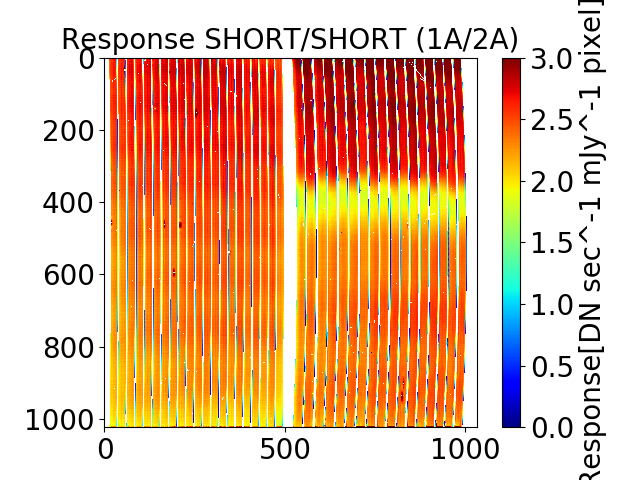

In [35]:
plt.figure()
plt.imshow(resp, interpolation="nearest", vmin=0,vmax=3,cmap='jet')
clb = plt.colorbar()
clb.set_label('Response[DN sec^-1 mJy^-1 pixel]')
plt.title("Response SHORT/SHORT (1A/2A)")

### Remarks:
The fringe correction is not correct for the internal calibration source. However our plan is to take the ratio of the nominal and cross-dichroic responses. The fringes there match, thus they will effectively disappear.

<IPython.core.display.Javascript object>


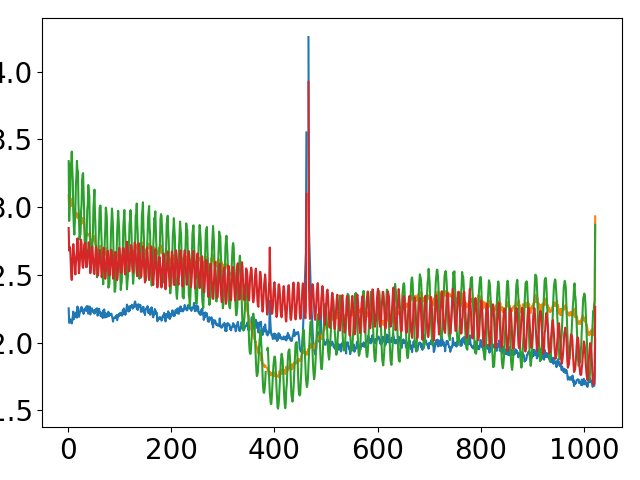

In [44]:
plt.figure()
plt.plot(resp[:,210])
plt.plot(resp[:,800])
plt.plot(R_pixMap["2A"][:,800])
plt.plot(R_pixMap["1A"][:,210])
plt.tight_layout()

# SHORT MEDIUM = 1B / 2B

In [48]:
hdu0 = makeHeader(detector="MIRIFUSHORT", channel="12", band="MEDIUM")
resp = R_pixMap["2B"].copy()
err = dR_pixMap["2B"].copy() 
size = sizeMap["2B"].copy()

sel = (validMap["1B"]==1)
resp[sel] = R_pixMap["1B"][sel]
err[sel] = dR_pixMap["1B"][sel]
size[sel] = sizeMap["1B"][sel]

sel = (( validMap["1B"] + validMap["2B"] )==1)
resp[sel] = resp[sel]/ff["SHORTMEDIUM"][sel]

dq = np.full( validMap["1B"].shape, 2 )
sel = (validMap["1B"]==1)
dq[sel] = 0
sel = (validMap["2B"]==1)
dq[sel] = 0
dq = dq + BadPixelMap["1B"]
dq = dq + BadPixelMap["2B"]

hdu1 = fits.ImageHDU(data=resp, header=None, name="SCI")
hdu1.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu2 = fits.ImageHDU(data=err, header=None, name="ERR")
hdu2.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu3 = fits.ImageHDU(data=dq, header=None, name="DQ")
hdu4 = fits.ImageHDU(data=size, header=None, name="PIXSIZ")
hdu4.header["BUNIT"]= "arcsec^2"
hdulist = fits.HDUList([hdu0,hdu1, hdu2, hdu3, dq_def, hdu4])
hdulist.writeto(outDir + "MIRI_FM_MIRIFUSHORT_12MEDIUM_PHOTOM_7B.04.00.fits",overwrite=True)

In [46]:
hdu0 = makeHeader(detector="MIRIFUSHORT", channel="12", band="MEDIUM")
resp = R_pixMap_STRCORR["2B"].copy()
err = dR_pixMap["2B"].copy() 
size = sizeMap["2B"].copy()

sel = (validMap["1B"]==1)
resp[sel] = R_pixMap_STRCORR["1B"][sel]
err[sel] = dR_pixMap["1B"][sel]
size[sel] = sizeMap["1B"][sel]

sel = (( validMap["1B"] + validMap["2B"] )==1)
resp[sel] = resp[sel]/ff["SHORTMEDIUM"][sel]

dq = np.full( validMap["1B"].shape, 2 )
sel = (validMap["1B"]==1)
dq[sel] = 0
sel = (validMap["2B"]==1)
dq[sel] = 0
dq = dq + BadPixelMap["1B"]
dq = dq + BadPixelMap["2B"]

hdu1 = fits.ImageHDU(data=resp, header=None, name="SCI")
hdu1.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu2 = fits.ImageHDU(data=err, header=None, name="ERR")
hdu2.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu3 = fits.ImageHDU(data=dq, header=None, name="DQ")
hdu4 = fits.ImageHDU(data=size, header=None, name="PIXSIZ")
hdu4.header["BUNIT"]= "arcsec^2"
hdulist = fits.HDUList([hdu0,hdu1, hdu2, hdu3, dq_def, hdu4])
hdulist.writeto(outDir + "MIRI_FM_MIRIFUSHORT_12MEDIUM_PHOTOM_7B.05.00.fits",overwrite=True)

<IPython.core.display.Javascript object>


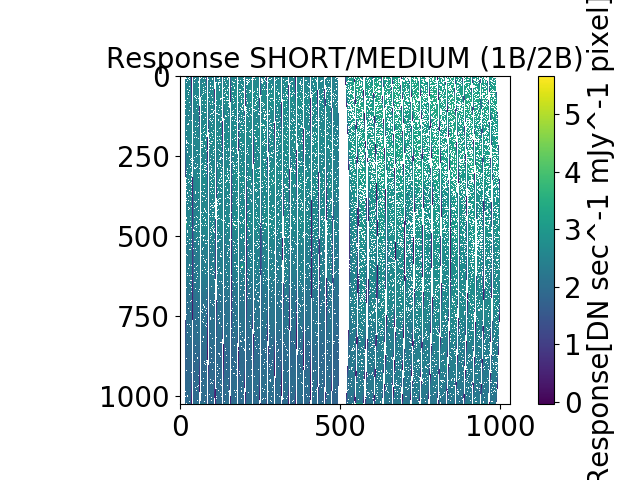

In [50]:
plt.figure()
plt.imshow(resp, interpolation="nearest")
clb = plt.colorbar()
clb.set_label('Response[DN sec^-1 mJy^-1 pixel]')
plt.title("Response SHORT/MEDIUM (1B/2B)")
plt.tight_layout()

<IPython.core.display.Javascript object>


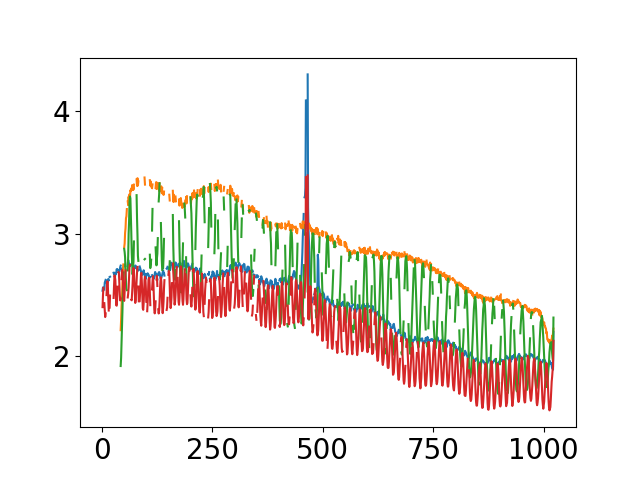

In [51]:
plt.figure()
plt.plot(resp[:,210])
plt.plot(resp[:,800])
plt.plot(R_pixMap["2B"][:,800])
plt.plot(R_pixMap["1B"][:,210])


# SHORT MEDIUM = 1C / 2C

In [52]:
hdu0 = makeHeader(detector="MIRIFUSHORT", channel="12", band="LONG")
resp = R_pixMap["2C"].copy()
err = dR_pixMap["2C"].copy() 
size = sizeMap["2C"].copy()

sel = (validMap["1C"]==1)
resp[sel] = R_pixMap["1C"][sel]
err[sel] = dR_pixMap["1C"][sel]
size[sel] = sizeMap["1C"][sel]

sel = (( validMap["1C"] + validMap["2C"] )==1)
resp[sel] = resp[sel]/ff["SHORTLONG"][sel]

dq = np.full( validMap["1C"].shape, 2 )
sel = (validMap["1C"]==1)
dq[sel] = 0
sel = (validMap["2C"]==1)
dq[sel] = 0
dq = dq + BadPixelMap["1C"]
dq = dq + BadPixelMap["2C"]

hdu1 = fits.ImageHDU(data=resp, header=None, name="SCI")
hdu1.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu2 = fits.ImageHDU(data=err, header=None, name="ERR")
hdu2.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu3 = fits.ImageHDU(data=dq, header=None, name="DQ")
hdu4 = fits.ImageHDU(data=size, header=None, name="PIXSIZ")
hdu4.header["BUNIT"]= "arcsec^2"
hdulist = fits.HDUList([hdu0,hdu1, hdu2, hdu3, dq_def, hdu4])
hdulist.writeto(outDir + "MIRI_FM_MIRIFUSHORT_12LONG_PHOTOM_7B.04.00.fits",overwrite=True)

In [53]:
hdu0 = makeHeader(detector="MIRIFUSHORT", channel="12", band="LONG")
resp = R_pixMap_STRCORR["2C"].copy()
err = dR_pixMap["2C"].copy() 
size = sizeMap["2C"].copy()

sel = (validMap["1C"]==1)
resp[sel] = R_pixMap_STRCORR["1C"][sel]
err[sel] = dR_pixMap["1C"][sel]
size[sel] = sizeMap["1C"][sel]

sel = (( validMap["1C"] + validMap["2C"] )==1)
resp[sel] = resp[sel]/ff["SHORTLONG"][sel]

dq = np.full( validMap["1C"].shape, 2 )
sel = (validMap["1C"]==1)
dq[sel] = 0
sel = (validMap["2C"]==1)
dq[sel] = 0
dq = dq + BadPixelMap["1C"]
dq = dq + BadPixelMap["2C"]

hdu1 = fits.ImageHDU(data=resp, header=None, name="SCI")
hdu1.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu2 = fits.ImageHDU(data=err, header=None, name="ERR")
hdu2.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu3 = fits.ImageHDU(data=dq, header=None, name="DQ")
hdu4 = fits.ImageHDU(data=size, header=None, name="PIXSIZ")
hdu4.header["BUNIT"]= "arcsec^2"
hdulist = fits.HDUList([hdu0,hdu1, hdu2, hdu3, dq_def, hdu4])
hdulist.writeto(outDir + "MIRI_FM_MIRIFUSHORT_12LONG_PHOTOM_7B.05.00.fits",overwrite=True)

<IPython.core.display.Javascript object>


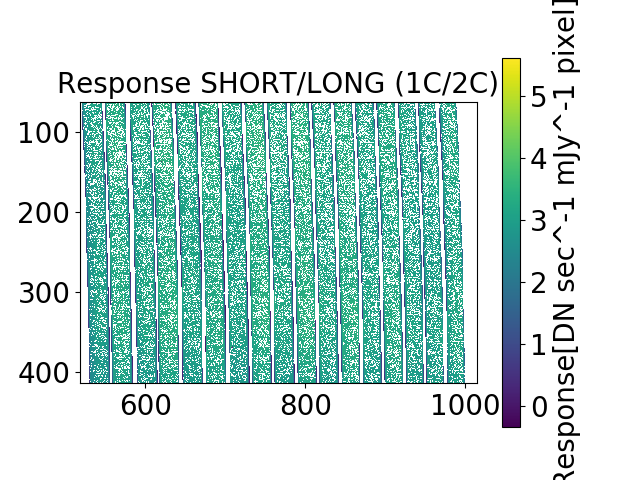

In [54]:
plt.figure()
plt.imshow(resp, interpolation="nearest")
clb = plt.colorbar()
clb.set_label('Response[DN sec^-1 mJy^-1 pixel]')
plt.title("Response SHORT/LONG (1C/2C)")

<IPython.core.display.Javascript object>


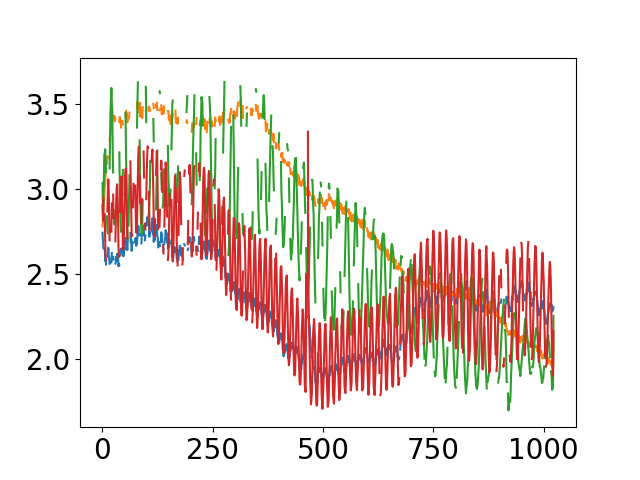

In [55]:
plt.figure()
plt.plot(resp[:,210])
plt.plot(resp[:,800])
plt.plot(R_pixMap["2C"][:,800])
plt.plot(R_pixMap["1C"][:,210])


# LONG SHORT = 3A / 4A

In [20]:
hdu0 = makeHeader(detector="MIRIFULONG", channel="34", band="SHORT")
resp = R_pixMap["4A"].copy()
err = dR_pixMap["4A"].copy() 
size = sizeMap["4A"].copy()

sel = (validMap["3A"]==1)
resp[sel] = R_pixMap["3A"][sel]
err[sel] = dR_pixMap["3A"][sel]
size[sel] = sizeMap["3A"][sel]

sel = (( validMap["3A"] + validMap["4A"] )==1)
resp[sel] = resp[sel]/ff["LONGSHORT"][sel]

dq = np.full( validMap["3A"].shape, 2 )
sel = (validMap["3A"]==1)
dq[sel] = 0
sel = (validMap["4A"]==1)
dq[sel] = 0
dq = dq + BadPixelMap["3A"]
dq = dq + BadPixelMap["4A"]

hdu1 = fits.ImageHDU(data=resp, header=None, name="SCI")
hdu1.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu2 = fits.ImageHDU(data=err, header=None, name="ERR")
hdu2.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu3 = fits.ImageHDU(data=dq, header=None, name="DQ")
hdu4 = fits.ImageHDU(data=size, header=None, name="PIXSIZ")
hdu4.header["BUNIT"]= "arcsec^2"
hdulist = fits.HDUList([hdu0,hdu1, hdu2, hdu3, dq_def, hdu4])
hdulist.writeto(outDir + "MIRI_FM_MIRIFULONG_34SHORT_PHOTOM_7B.04.00.fits",overwrite=True)

<IPython.core.display.Javascript object>


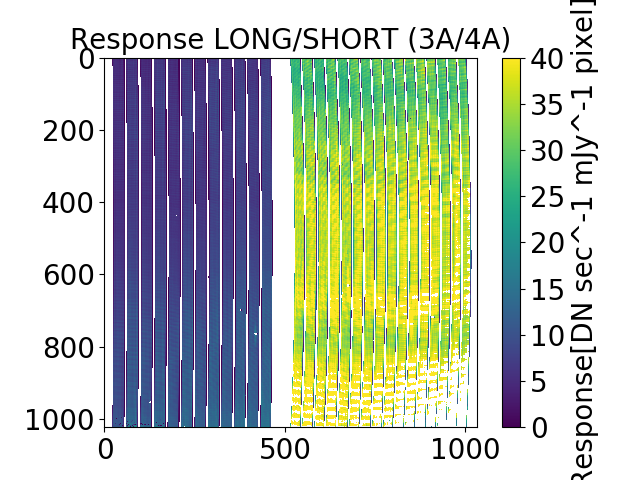

In [21]:
plt.figure()
plt.imshow(resp, interpolation="nearest", vmin=0,vmax=40)
clb = plt.colorbar()
clb.set_label('Response[DN sec^-1 mJy^-1 pixel]')
plt.title("Response LONG/SHORT (3A/4A)")

<IPython.core.display.Javascript object>


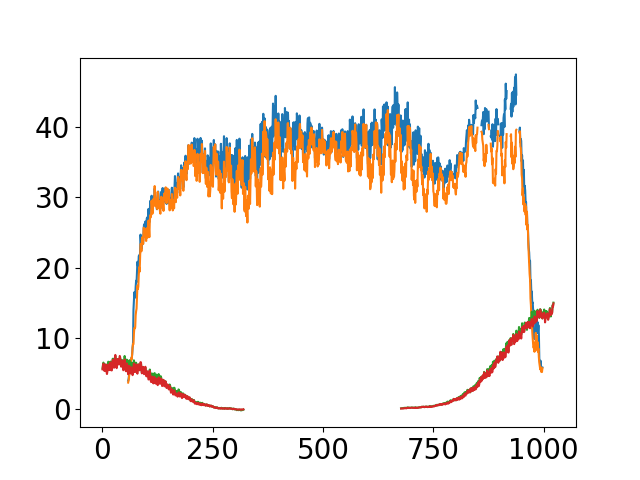

In [22]:
plt.figure()
plt.plot(resp[:,800])
plt.plot(R_pixMap["3A"][:,800])
plt.plot(resp[:,215])
plt.plot(R_pixMap["4A"][:,215])


# LONG MEDIUM = 3B / 4B

In [23]:
hdu0 = makeHeader(detector="MIRIFULONG", channel="34", band="MEDIUM")
resp = R_pixMap["4B"].copy()
err = dR_pixMap["4B"].copy() 
size = sizeMap["4B"].copy()

sel = (validMap["3B"]==1)
resp[sel] = R_pixMap["3B"][sel]
err[sel] = dR_pixMap["3B"][sel]
size[sel] = sizeMap["3B"][sel]

sel = (( validMap["3B"] + validMap["4B"] )==1)
resp[sel] = resp[sel]/ff["LONGMEDIUM"][sel]

dq = np.full( validMap["3B"].shape, 2 )
sel = (validMap["3B"]==1)
dq[sel] = 0
sel = (validMap["4B"]==1)
dq[sel] = 0
dq = dq + BadPixelMap["3B"]
dq = dq + BadPixelMap["4B"]

hdu1 = fits.ImageHDU(data=resp, header=None, name="SCI")
hdu1.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu2 = fits.ImageHDU(data=err, header=None, name="ERR")
hdu2.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu3 = fits.ImageHDU(data=dq, header=None, name="DQ")
hdu4 = fits.ImageHDU(data=size, header=None, name="PIXSIZ")
hdu4.header["BUNIT"]= "arcsec^2"
hdulist = fits.HDUList([hdu0,hdu1, hdu2, hdu3, dq_def, hdu4])
hdulist.writeto(outDir + "MIRI_FM_MIRIFULONG_34MEDIUM_PHOTOM_7B.04.00.fits",overwrite=True)

<IPython.core.display.Javascript object>


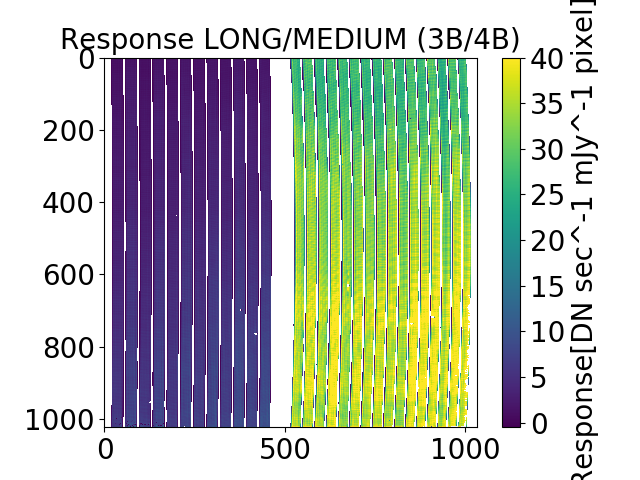

In [24]:
plt.figure()
plt.imshow(resp, interpolation="nearest",vmax=40)
clb = plt.colorbar()
clb.set_label('Response[DN sec^-1 mJy^-1 pixel]')
plt.title("Response LONG/MEDIUM (3B/4B)")

<IPython.core.display.Javascript object>


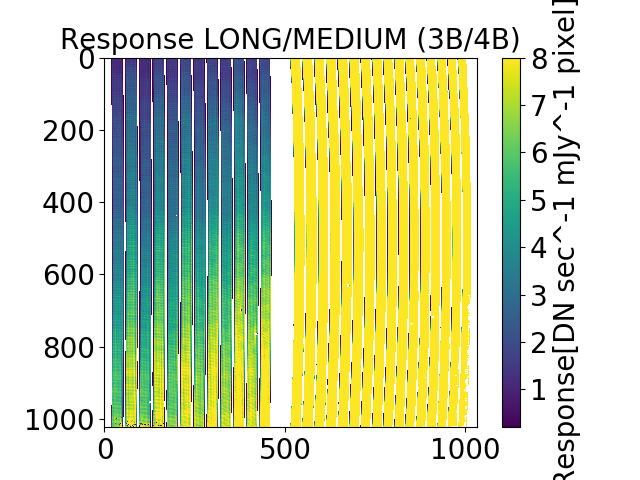

In [25]:
plt.figure()
plt.imshow(resp, interpolation="nearest", vmin=0.2, vmax=8)
clb = plt.colorbar()
clb.set_label('Response[DN sec^-1 mJy^-1 pixel]')
plt.title("Response LONG/MEDIUM (3B/4B)")

<IPython.core.display.Javascript object>


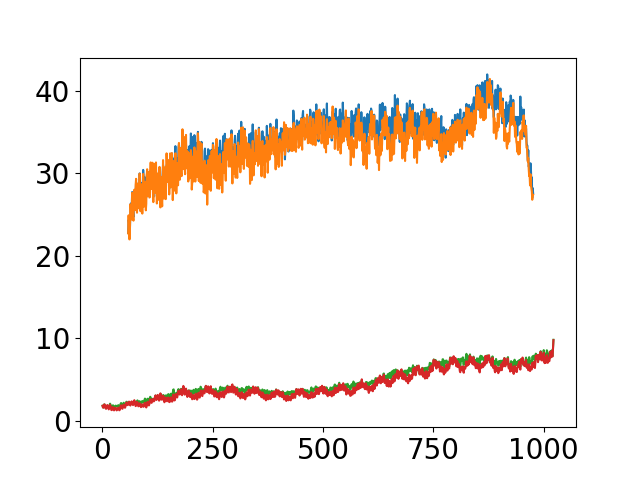

In [26]:
plt.figure()
plt.plot(resp[:,800])
plt.plot(R_pixMap["3B"][:,800])
plt.plot(resp[:,215])
plt.plot(R_pixMap["4B"][:,215])


# LONG LONG = 3C / 4C

In [27]:
hdu0 = makeHeader(detector="MIRIFULONG", channel="34", band="LONG")
resp = R_pixMap["4C"].copy()
err = dR_pixMap["4C"].copy() 
size = sizeMap["4C"].copy()

sel = (validMap["3C"]==1)
resp[sel] = R_pixMap["3C"][sel]
err[sel] = dR_pixMap["3C"][sel]
size[sel] = sizeMap["3C"][sel]

sel = (( validMap["3C"] + validMap["4C"] )==1)
resp[sel] = resp[sel]/ff["LONGLONG"][sel]

dq = np.full( validMap["3C"].shape, 2 )
sel = (validMap["3C"]==1)
dq[sel] = 0
sel = (validMap["4C"]==1)
dq[sel] = 0
dq = dq + BadPixelMap["3C"]
dq = dq + BadPixelMap["4C"]

hdu1 = fits.ImageHDU(data=resp, header=None, name="SCI")
hdu1.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu2 = fits.ImageHDU(data=err, header=None, name="ERR")
hdu2.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu3 = fits.ImageHDU(data=dq, header=None, name="DQ")
hdu4 = fits.ImageHDU(data=size, header=None, name="PIXSIZ")
hdu4.header["BUNIT"]= "arcsec^2"
hdulist = fits.HDUList([hdu0,hdu1, hdu2, hdu3, dq_def, hdu4])
hdulist.writeto(outDir + "MIRI_FM_MIRIFULONG_34LONG_PHOTOM_7B.04.00.fits",overwrite=True)

<IPython.core.display.Javascript object>


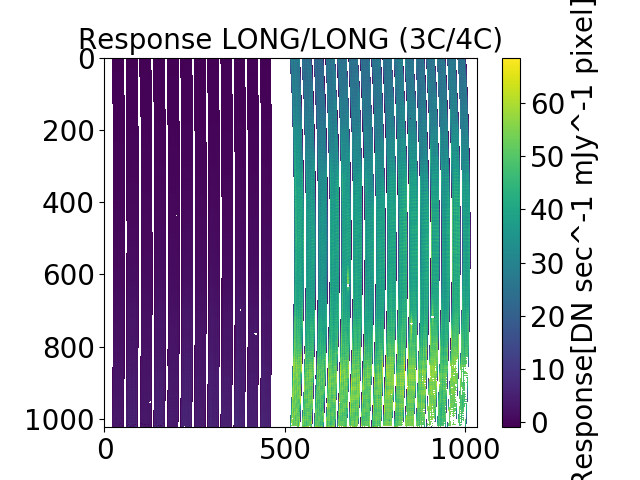

In [28]:
plt.figure()
plt.imshow(resp, interpolation="nearest")
clb = plt.colorbar()
clb.set_label('Response[DN sec^-1 mJy^-1 pixel]')
plt.title("Response LONG/LONG (3C/4C)")